In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg


import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, Lambda, MaxPooling2D, Cropping2D, AveragePooling2D,BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display # Allows the use of display() for DataFrames

# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = 'data'
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv(data_dir + '/driving_log.csv', header=None, names=columns)
data.iloc[:5]

,center,left,right,steering_angle,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print("Data loaded...")
print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

Data loaded...
Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max          1.000000     0.985533     1.000000    30.709360 



(160, 320, 3)


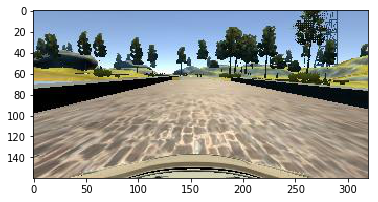

In [4]:
def read_image(file):
    # Readimage from file
    image = plt.imread('data/' + file)
    return image

def showImage(image, title):
    plt.imshow(image.squeeze())
    plt.show()

image = read_image(data['center'][0].strip())
print(image.shape)

showImage(image, 'Original ' + str(data['steering_angle'][0]) ) 

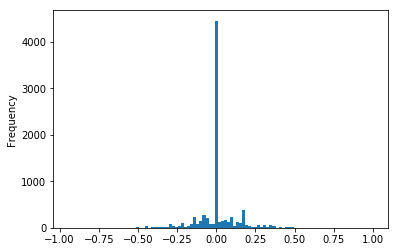

In [5]:
data['steering_angle'].plot.hist(bins=100)

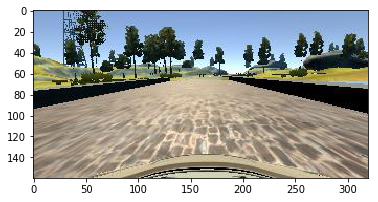

In [6]:
# flip images horizontally
def horizontal_flip(img):
    flipped_image = cv2.flip(img, 1)
    return flipped_image

fliped = horizontal_flip(image)
showImage(fliped, 'fliped ')


In [7]:
def random_flip(img,steering_angle,prob=0.5):
    if (np.random.random() < prob):
        img,steering_angle= cv2.flip(img,1),-steering_angle
    return img,steering_angle

""" adjust the brightness using a random factor for all pixels"""
def random_brightness(img, median = 0.8, dev = 0.4, prob=0.5):
    if (np.random.random() < prob):
        hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        factor = median + dev * np.random.uniform(-1.0, 1.0)
        #factor = (.5+np.random.uniform())
        hsv[:,:,2] = hsv[:,:,2]*factor
        filter = hsv[:,:,2]>255
        hsv[:,:,2][filter]  = 255
        img = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return img

"""sheer the  horizon by a small fraction"""
def random_shear(img, steering_angle, shear_range=200, prob =0.5):
    if np.random.random() < prob:
        h, w, ch = img.shape
        tx = np.random.randint(-shear_range, shear_range+1)
        steering_angle += tx / (h / 2) * 360 / (2 * np.pi * 25.0) / 6.0
        shear_point = [w / 2 + tx, h / 2]
        r1 = np.float32([[0, h], [w, h], [w / 2, h / 2]])
        r2 = np.float32([[0, h], [w, h], shear_point])
        transform_matrix = cv2.getAffineTransform(r1, r2)
        img = cv2.warpAffine(img, transform_matrix, (w, h), borderMode=1)
    return img, steering_angle

"""cast a random shaped shadow and overlay over the original image"""
def random_shadow(img):
    shadow = img.copy()
    h,w,ch = shadow.shape
    x1 = np.random.randint(0,int(w*0.4))
    x2 = np.random.randint(int(w*0.6),w-1)
    y1 = np.random.randint(0,int(h*0.2))
    y2 = np.random.randint(int(h*0.7),h-1)
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,0),-1)
    alpha = np.random.uniform(0.6, 0.9)
    img = cv2.addWeighted(shadow, alpha, img, 1-alpha,0,img)
    return img

"""pipe all the augmentation transforms together"""
def pipeline(img,steering_angle):
    img,steering_angle = random_flip(img,steering_angle)
    img = random_brightness(img)
    img = random_shadow(img)
    img,steering_angle = random_shear(img,steering_angle,prob=0.5)
    return img,steering_angle

In [8]:
data_train, data_val = train_test_split(data, test_size=0.2)

In [9]:
# Number of training examples
n_train = len(data_train)

# Number of testing examples.
n_val = len(data_val)

print("Number of train images =", n_train)
print("Number of n_val labels =", n_val)

Number of train images = 6428
Number of n_val labels = 1608


In [10]:
MODEL_IMG_CHANNELS = 3

def nvidia_model(summary=False):
    
    model = Sequential()
    # Crop the sky and bottom pixels, normalise and reduce dimensionality
    model.add(Cropping2D(((80,25),(1,1)), input_shape=[160, 320, 3], name="Crop2D"))
    model.add(BatchNormalization(axis=1, name="Normalise"))
    model.add(AveragePooling2D(pool_size=(1,4), name="Resize", trainable=False))

    # Successively learn through multiple convolutions, relu activations and pooling layers,
    model.add(Convolution2D(24, (3, 3), strides=(2,2), name="Conv1", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool1"))
    model.add(Convolution2D(48, (3, 3), strides=(1,1), name="Conv2", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool2"))
    model.add(Convolution2D(72, (3, 3), strides=(1,1), name="Conv3", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool3"))
    model.add(Dropout(0.2, name="Dropout1"))

    # Learn the steering angles through 3 fully connected layers
    model.add(Flatten(name="Flatten"))
    #model.add(Dense(1024, activation="relu", name="FC1"))
    model.add(Dense(100, activation="relu", name="FC2"))
    model.add(Dense(50, activation="relu", name="FC3"))
    model.add(Dense(10, activation="relu", name="FC4"))

    # Final Output  of steering angles
    model.add(Dense(1, name="Steering", activation='linear'))


    if summary:
        model.summary()
    return model

model = nvidia_model(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Crop2D (Cropping2D)          (None, 55, 318, 3)        0         
_________________________________________________________________
Normalise (BatchNormalizatio (None, 55, 318, 3)        220       
_________________________________________________________________
Resize (AveragePooling2D)    (None, 55, 79, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 27, 39, 24)        672       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 13, 19, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 11, 17, 48)        10416     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 5, 8, 48)          0         
__________

In [11]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

In [12]:
CAMARA_ANGLE = 0.3
ANGLE_SHIFT = 0.3

def _camera_data(batch):
    camera_data =[]
    for line in batch:
        if(len(line)>0):
            center_angle = float(line[3])
            rnd = np.random.randint(0, 3)
            path = line[rnd].split('/')[-1]
            filename = './data/IMG/'+path
            if (rnd ==1):
                camera_data.append((filename,center_angle + ANGLE_SHIFT))
            elif (rnd ==2):
                camera_data.append((filename,center_angle - ANGLE_SHIFT))
            else:
                camera_data.append((filename,center_angle ))
    return camera_data

def generator(records, batch_size=32, augment=False):
    while True:
        num_records = len(records)
        filter_indices = np.random.randint(0, num_records, batch_size)
        batch = np.array(records)[filter_indices]
        camera_data = _camera_data(batch)
        images =[]
        angles = []
        for filename, angle in camera_data:
            img = mpimg.imread(filename)
            #apply the augmentation trasforms when training
            if augment:
                img, angle = pipeline(img, float(angle))
            images.append(img)
            angles.append(float(angle))

        X = np.array(images)
        y = np.array(angles)

        # output a batch increment
        yield X, y

[ 0.3]
[-0.4287396]


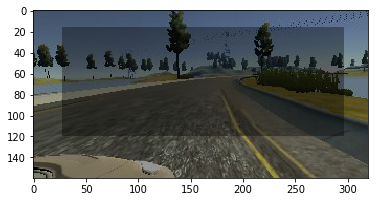

In [13]:
gen = generator( data_val, batch_size=1)        
x, y = next( gen )
print(y)     

gen = generator( data_val, batch_size=1, augment=True)        
x, y = next( gen )
print(y)     
showImage(x[0], 'Test' ) 


In [ ]:
gen_train = generator(data_train, augment=True)  
gen_val = generator(data_val)

In [ ]:
nb_epoch = 8
nb_samples_per_epoch = 2000
nb_val_samples = len(data_val)
learning_rate = 1e-4

history_object = model.fit_generator(gen_train,
                    steps_per_epoch=nb_samples_per_epoch,
                    validation_data=gen_val,
                    validation_steps=nb_val_samples, 
                    epochs=nb_epoch,
                    callbacks=[])

In [14]:
model.save("model.h5")
print("Saved model")

Saved model


In [19]:

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

NameError: name 'history_object' is not defined

In [21]:
from keras.models import load_model
model = load_model('model.h5')

In [25]:
image_array = np.asarray(x[0])
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
print(steering_angle)
print(y[0])

11.576290130615234
-0.3787459


In [26]:
# visualize model layers output

from keras import backend as K

def plotLayer(image, layer, factors = [9,8], figsize=(60,40)):

    layerOutput = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer].output])
    # output in test mode = 0, train mode = 1
    layerOutputSample = layerOutput([image.reshape(1,image.shape[0],image.shape[1],image.shape[2]), 1])[0]
    layerOutputSample = layerOutputSample.reshape(layerOutputSample.shape[1],layerOutputSample.shape[2],layerOutputSample.shape[3])
    print(layerOutputSample.shape)
    figure = plt.figure(figsize=figsize)
    for ind in range(layerOutputSample.shape[2]):
        plt.subplot(factors[0],factors[1],ind + 1)
        val = layerOutputSample[:,:,ind]
        plt.axis("off")
        plt.imshow(val, cmap='gray',interpolation='nearest')
    plt.tight_layout()   


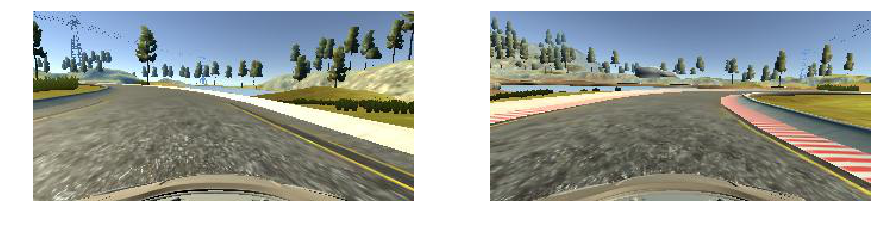

In [27]:
gen = generator( data_val, batch_size=1)  
x, y = next( gen )

plt.figure(figsize=(15, 10))

image_array_1 = np.asarray(x[0])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_array_1)

gen = generator( data_val, batch_size=1)        
x, y = next( gen )
image_array_2 = np.asarray(x[0])
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_array_2)

plt.show()

(27, 39, 24)


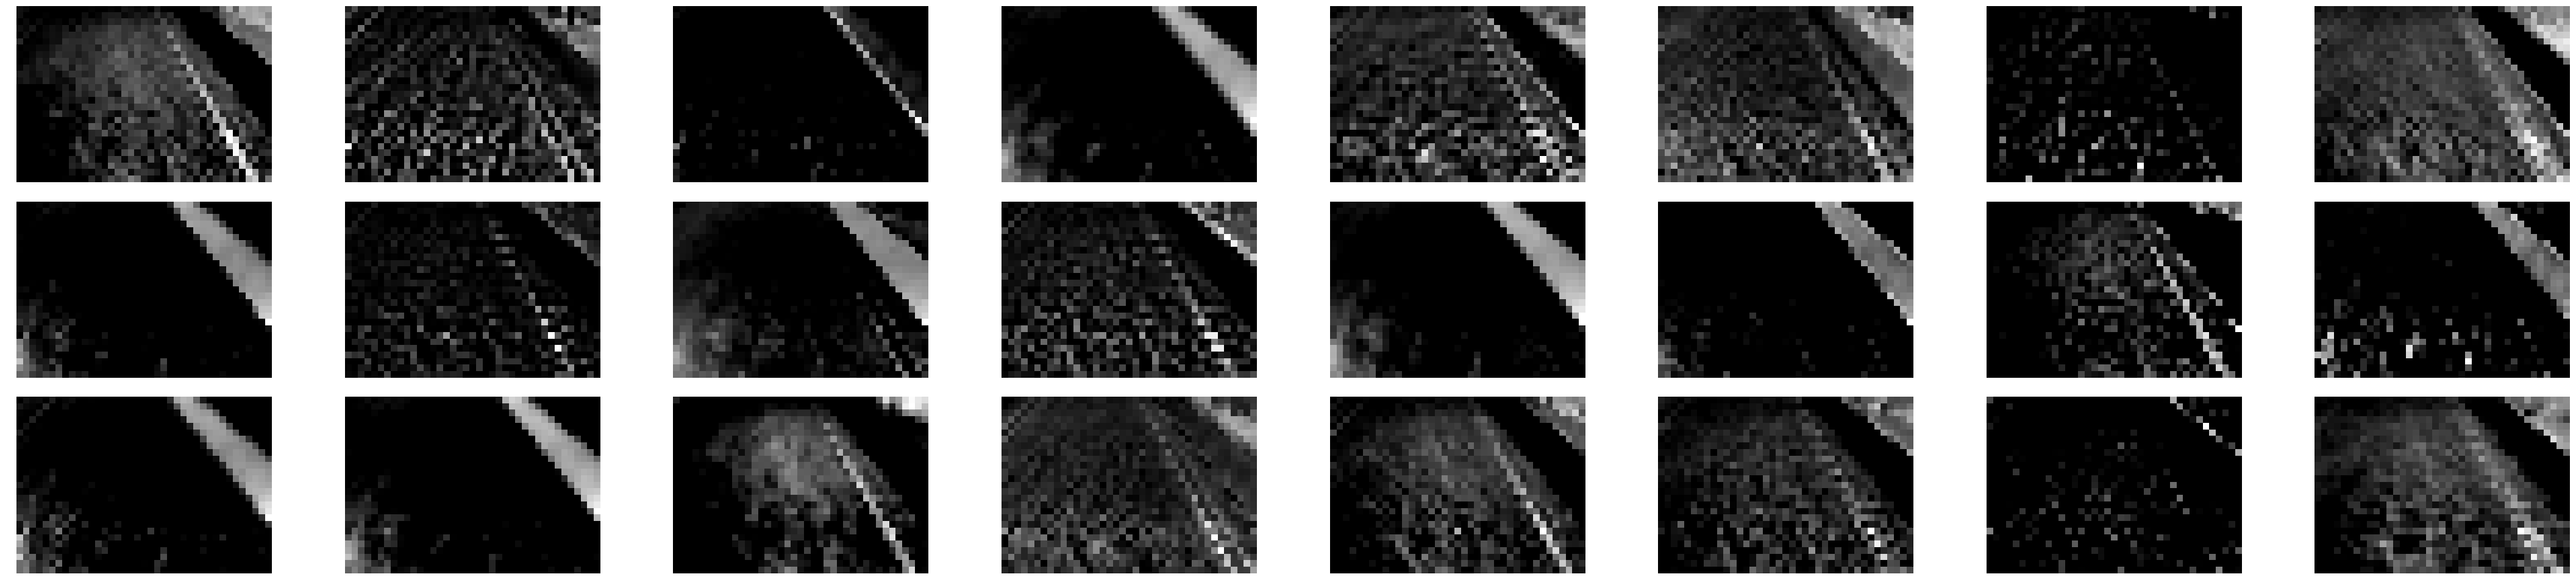

In [28]:
plotLayer(image_array_1, 3)

(27, 39, 24)


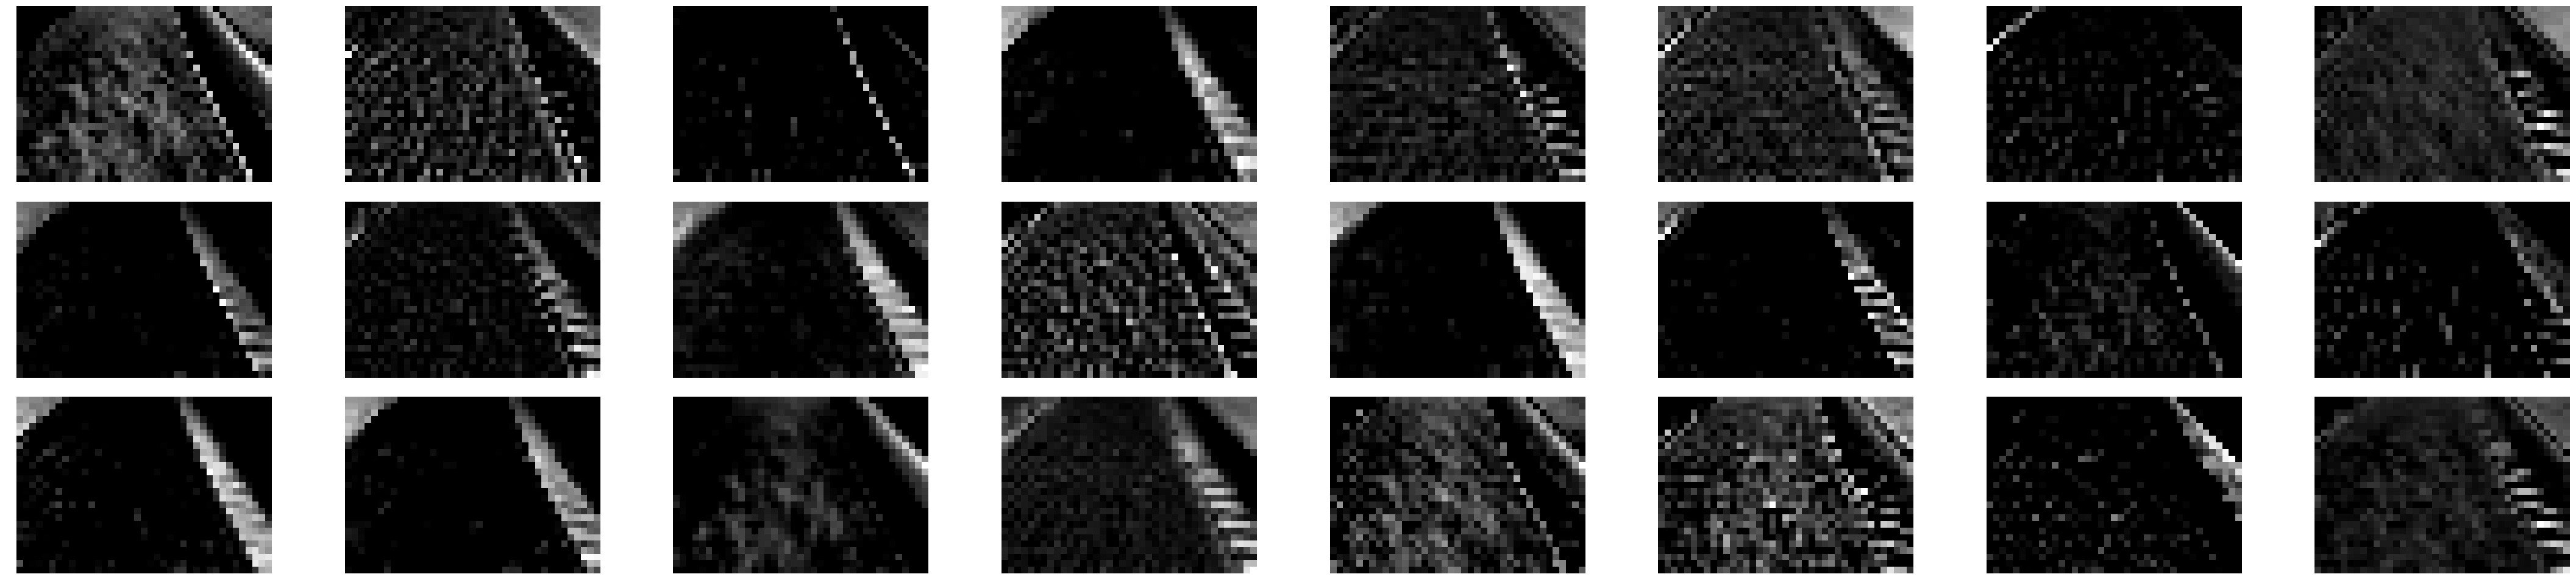

In [29]:
plotLayer(image_array_2, 3)

(11, 17, 48)


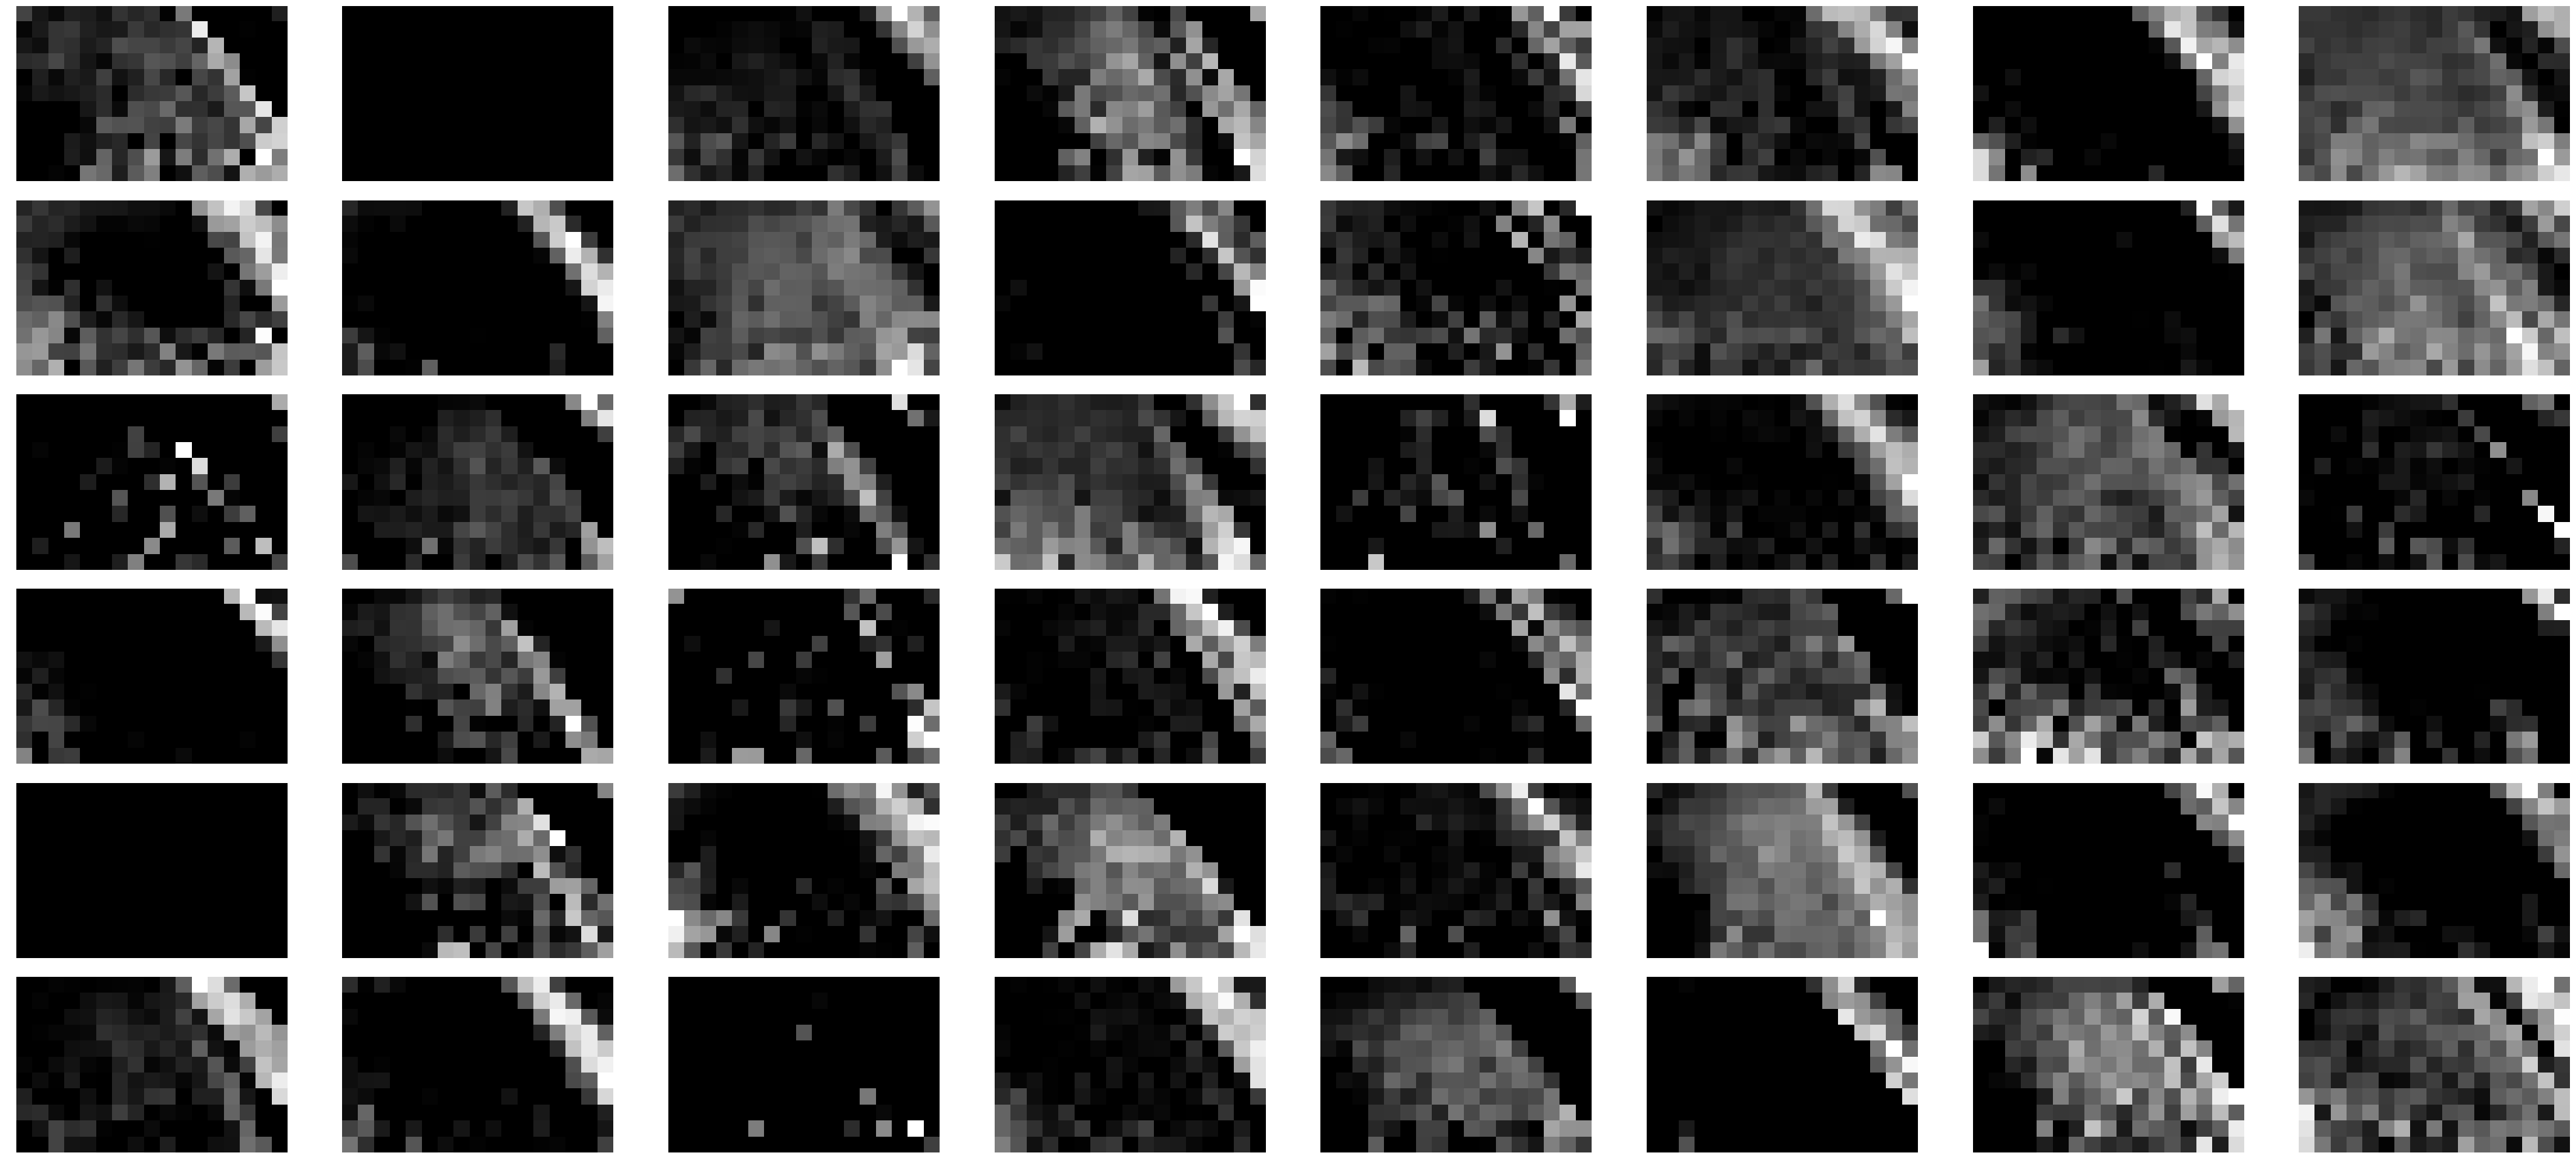

In [30]:
plotLayer(image_array_1, 5)

(11, 17, 48)


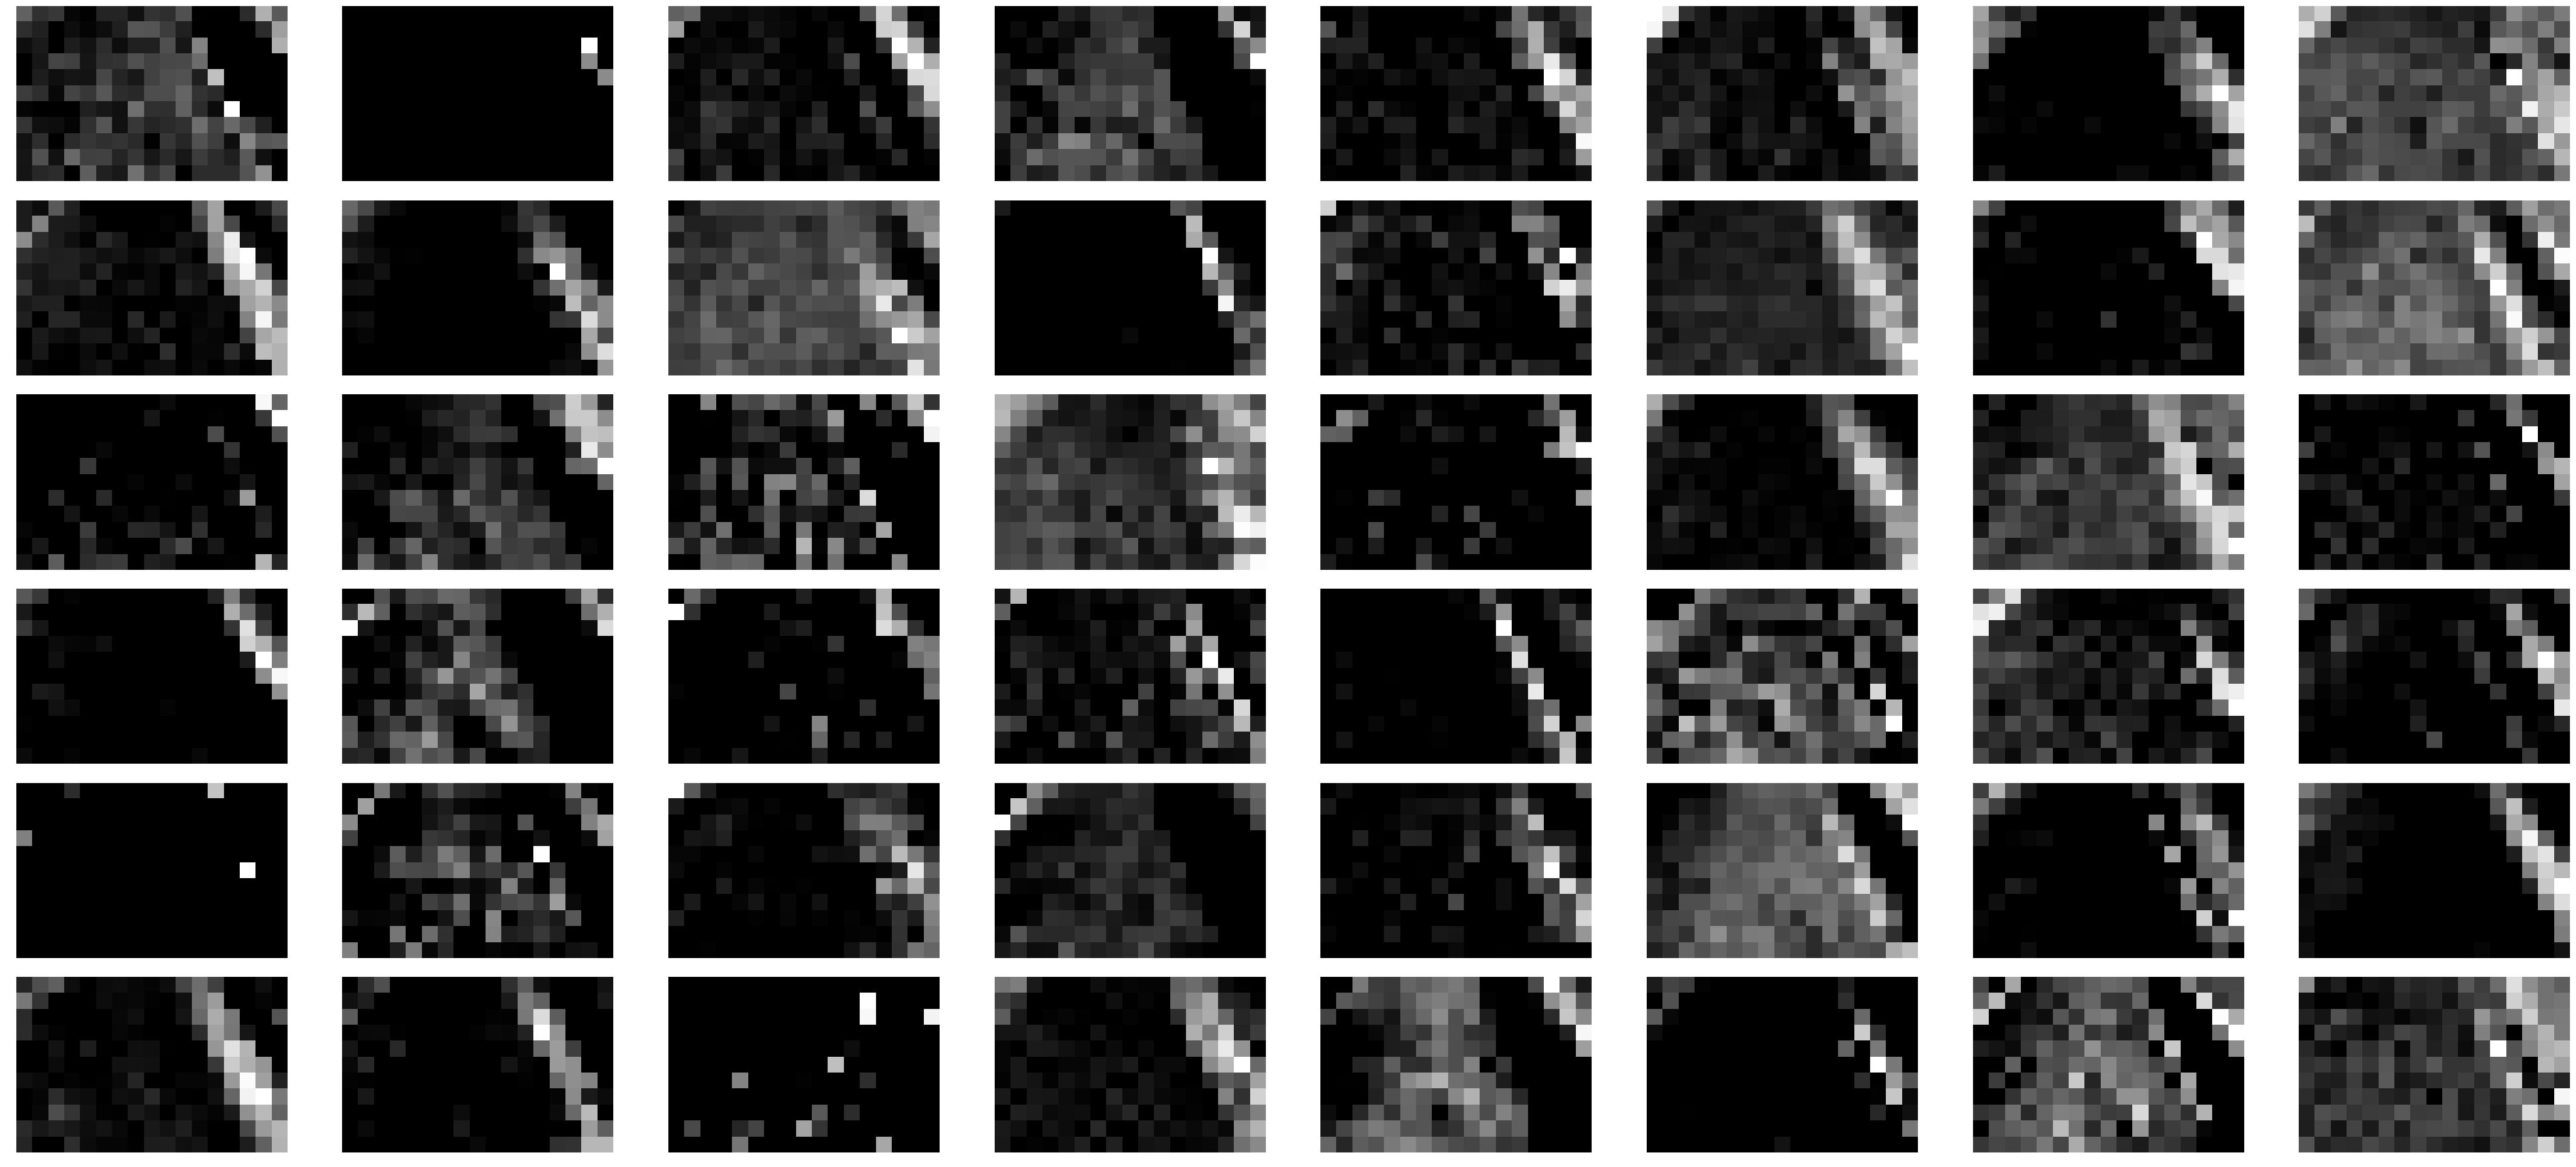

In [31]:
plotLayer(image_array_2, 5)

(3, 6, 72)


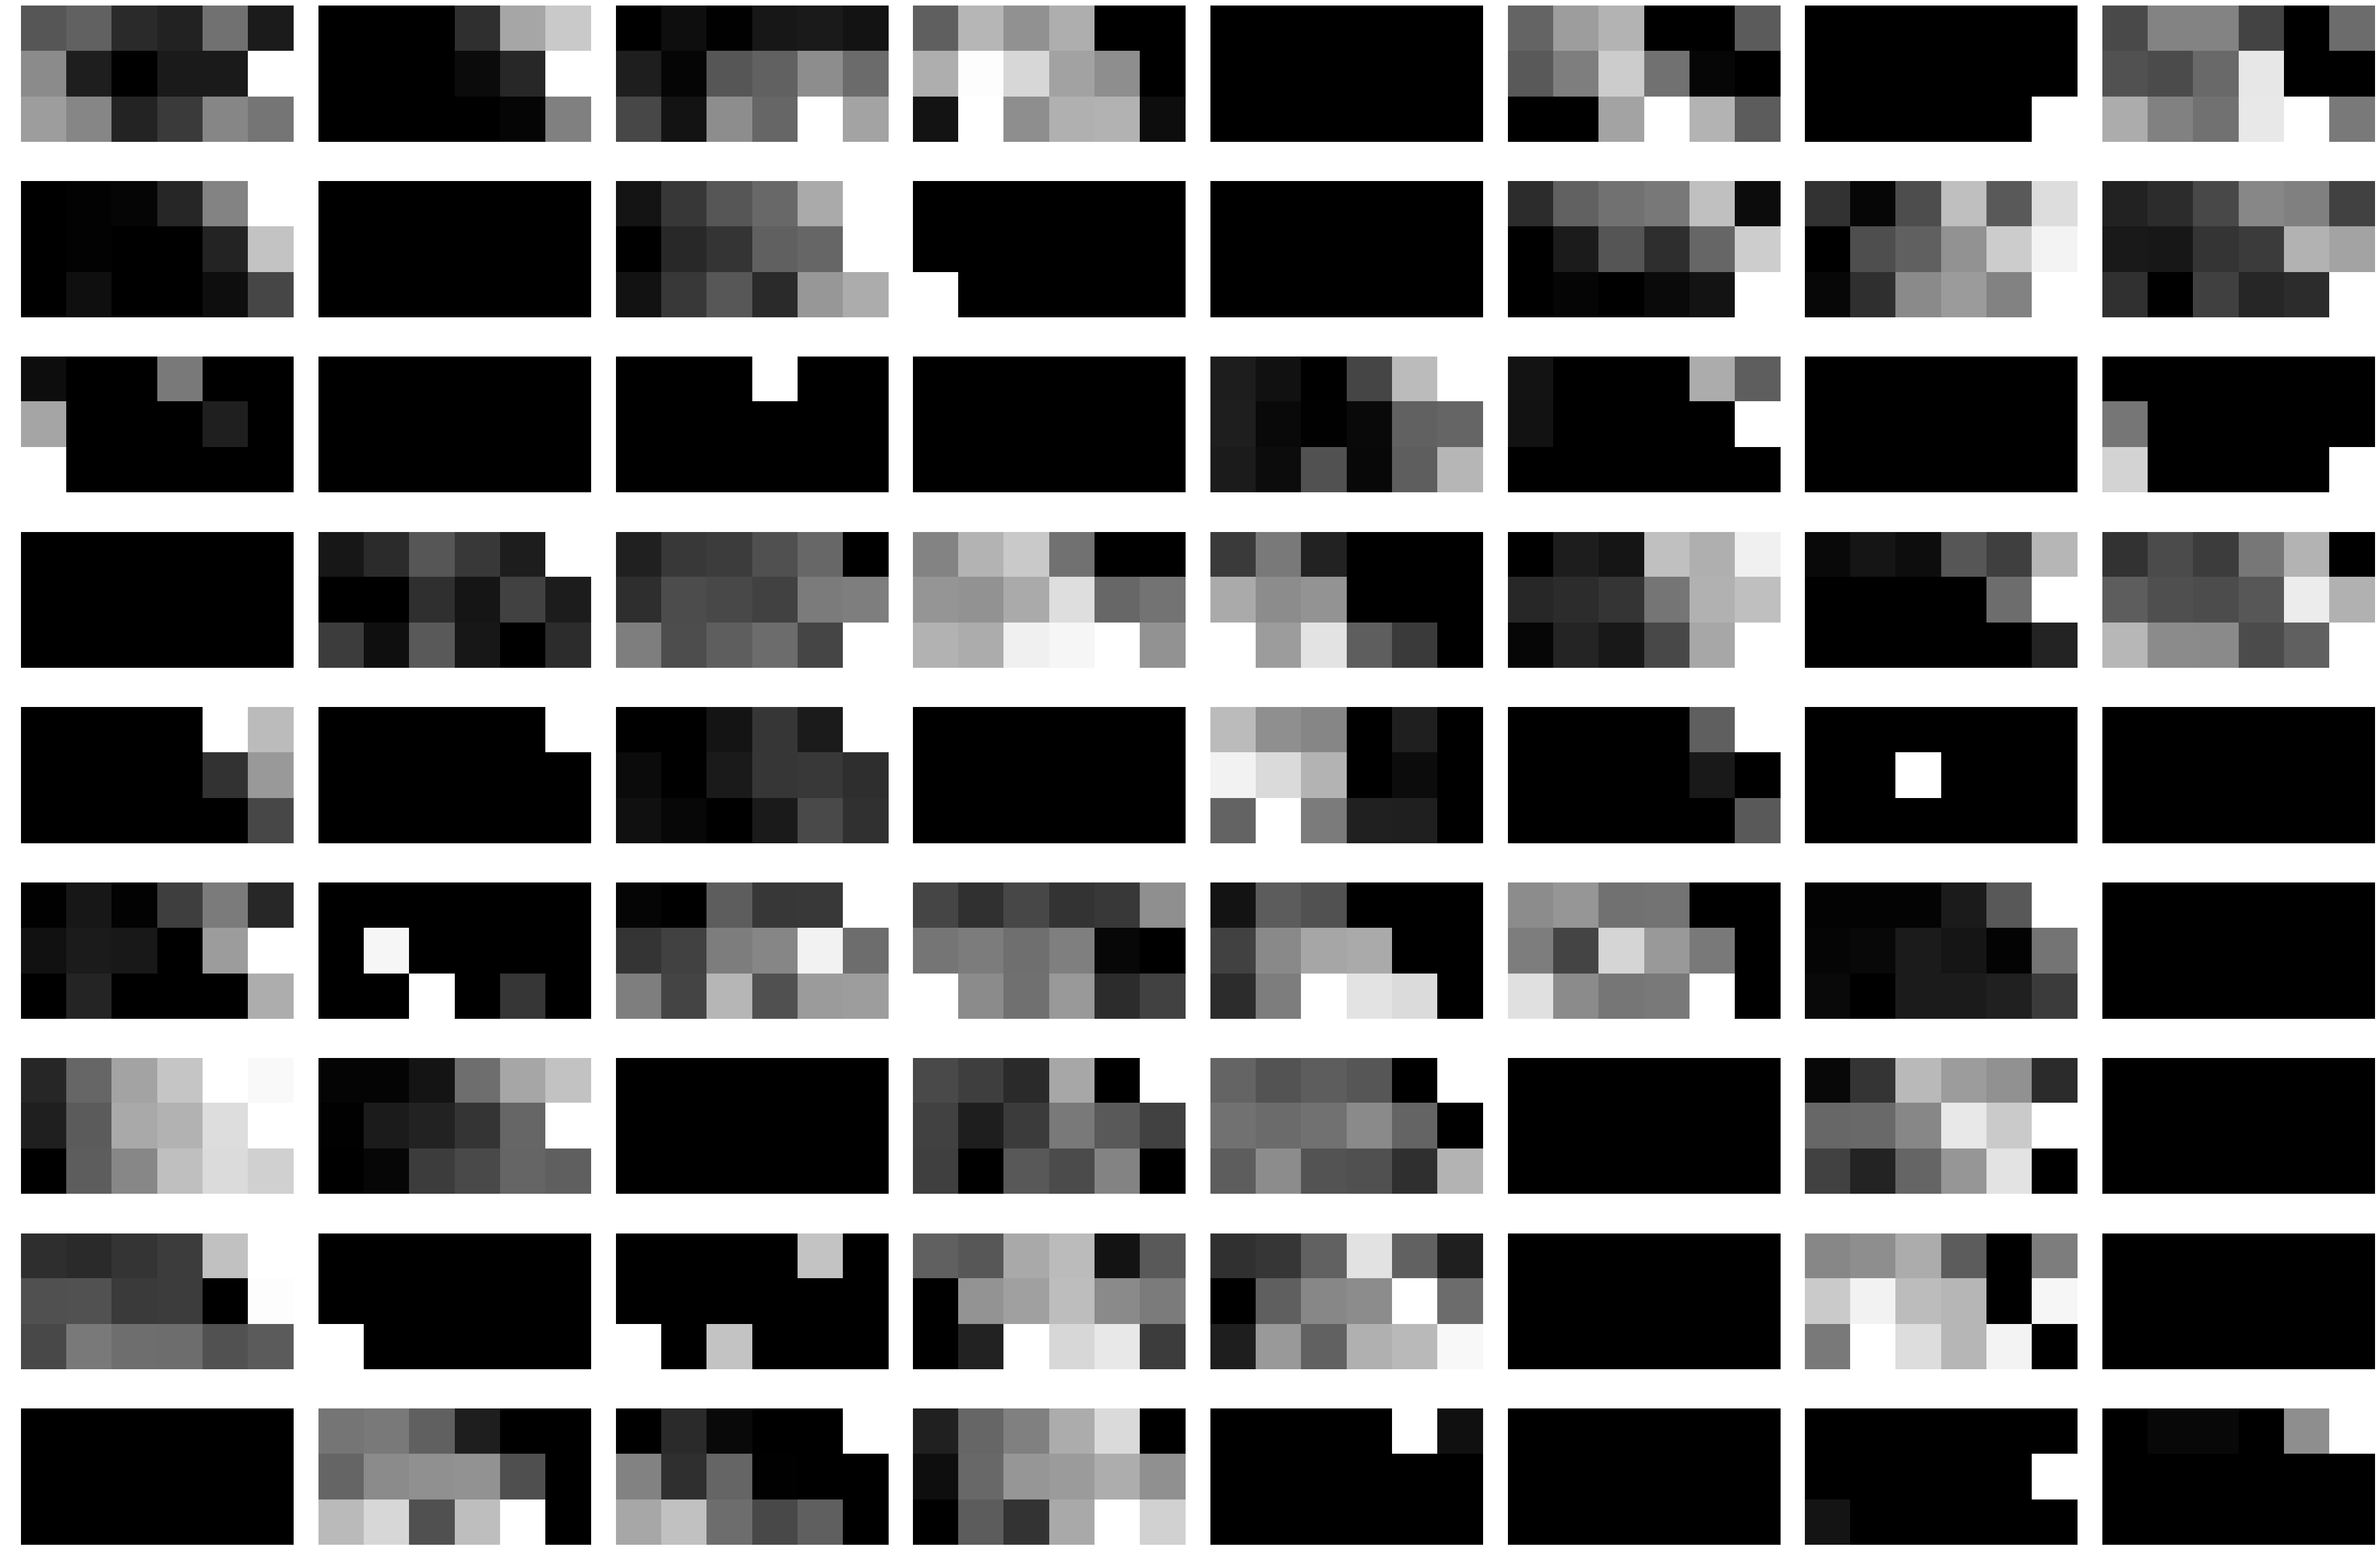

In [32]:
plotLayer(image_array_1, 7)

(3, 6, 72)


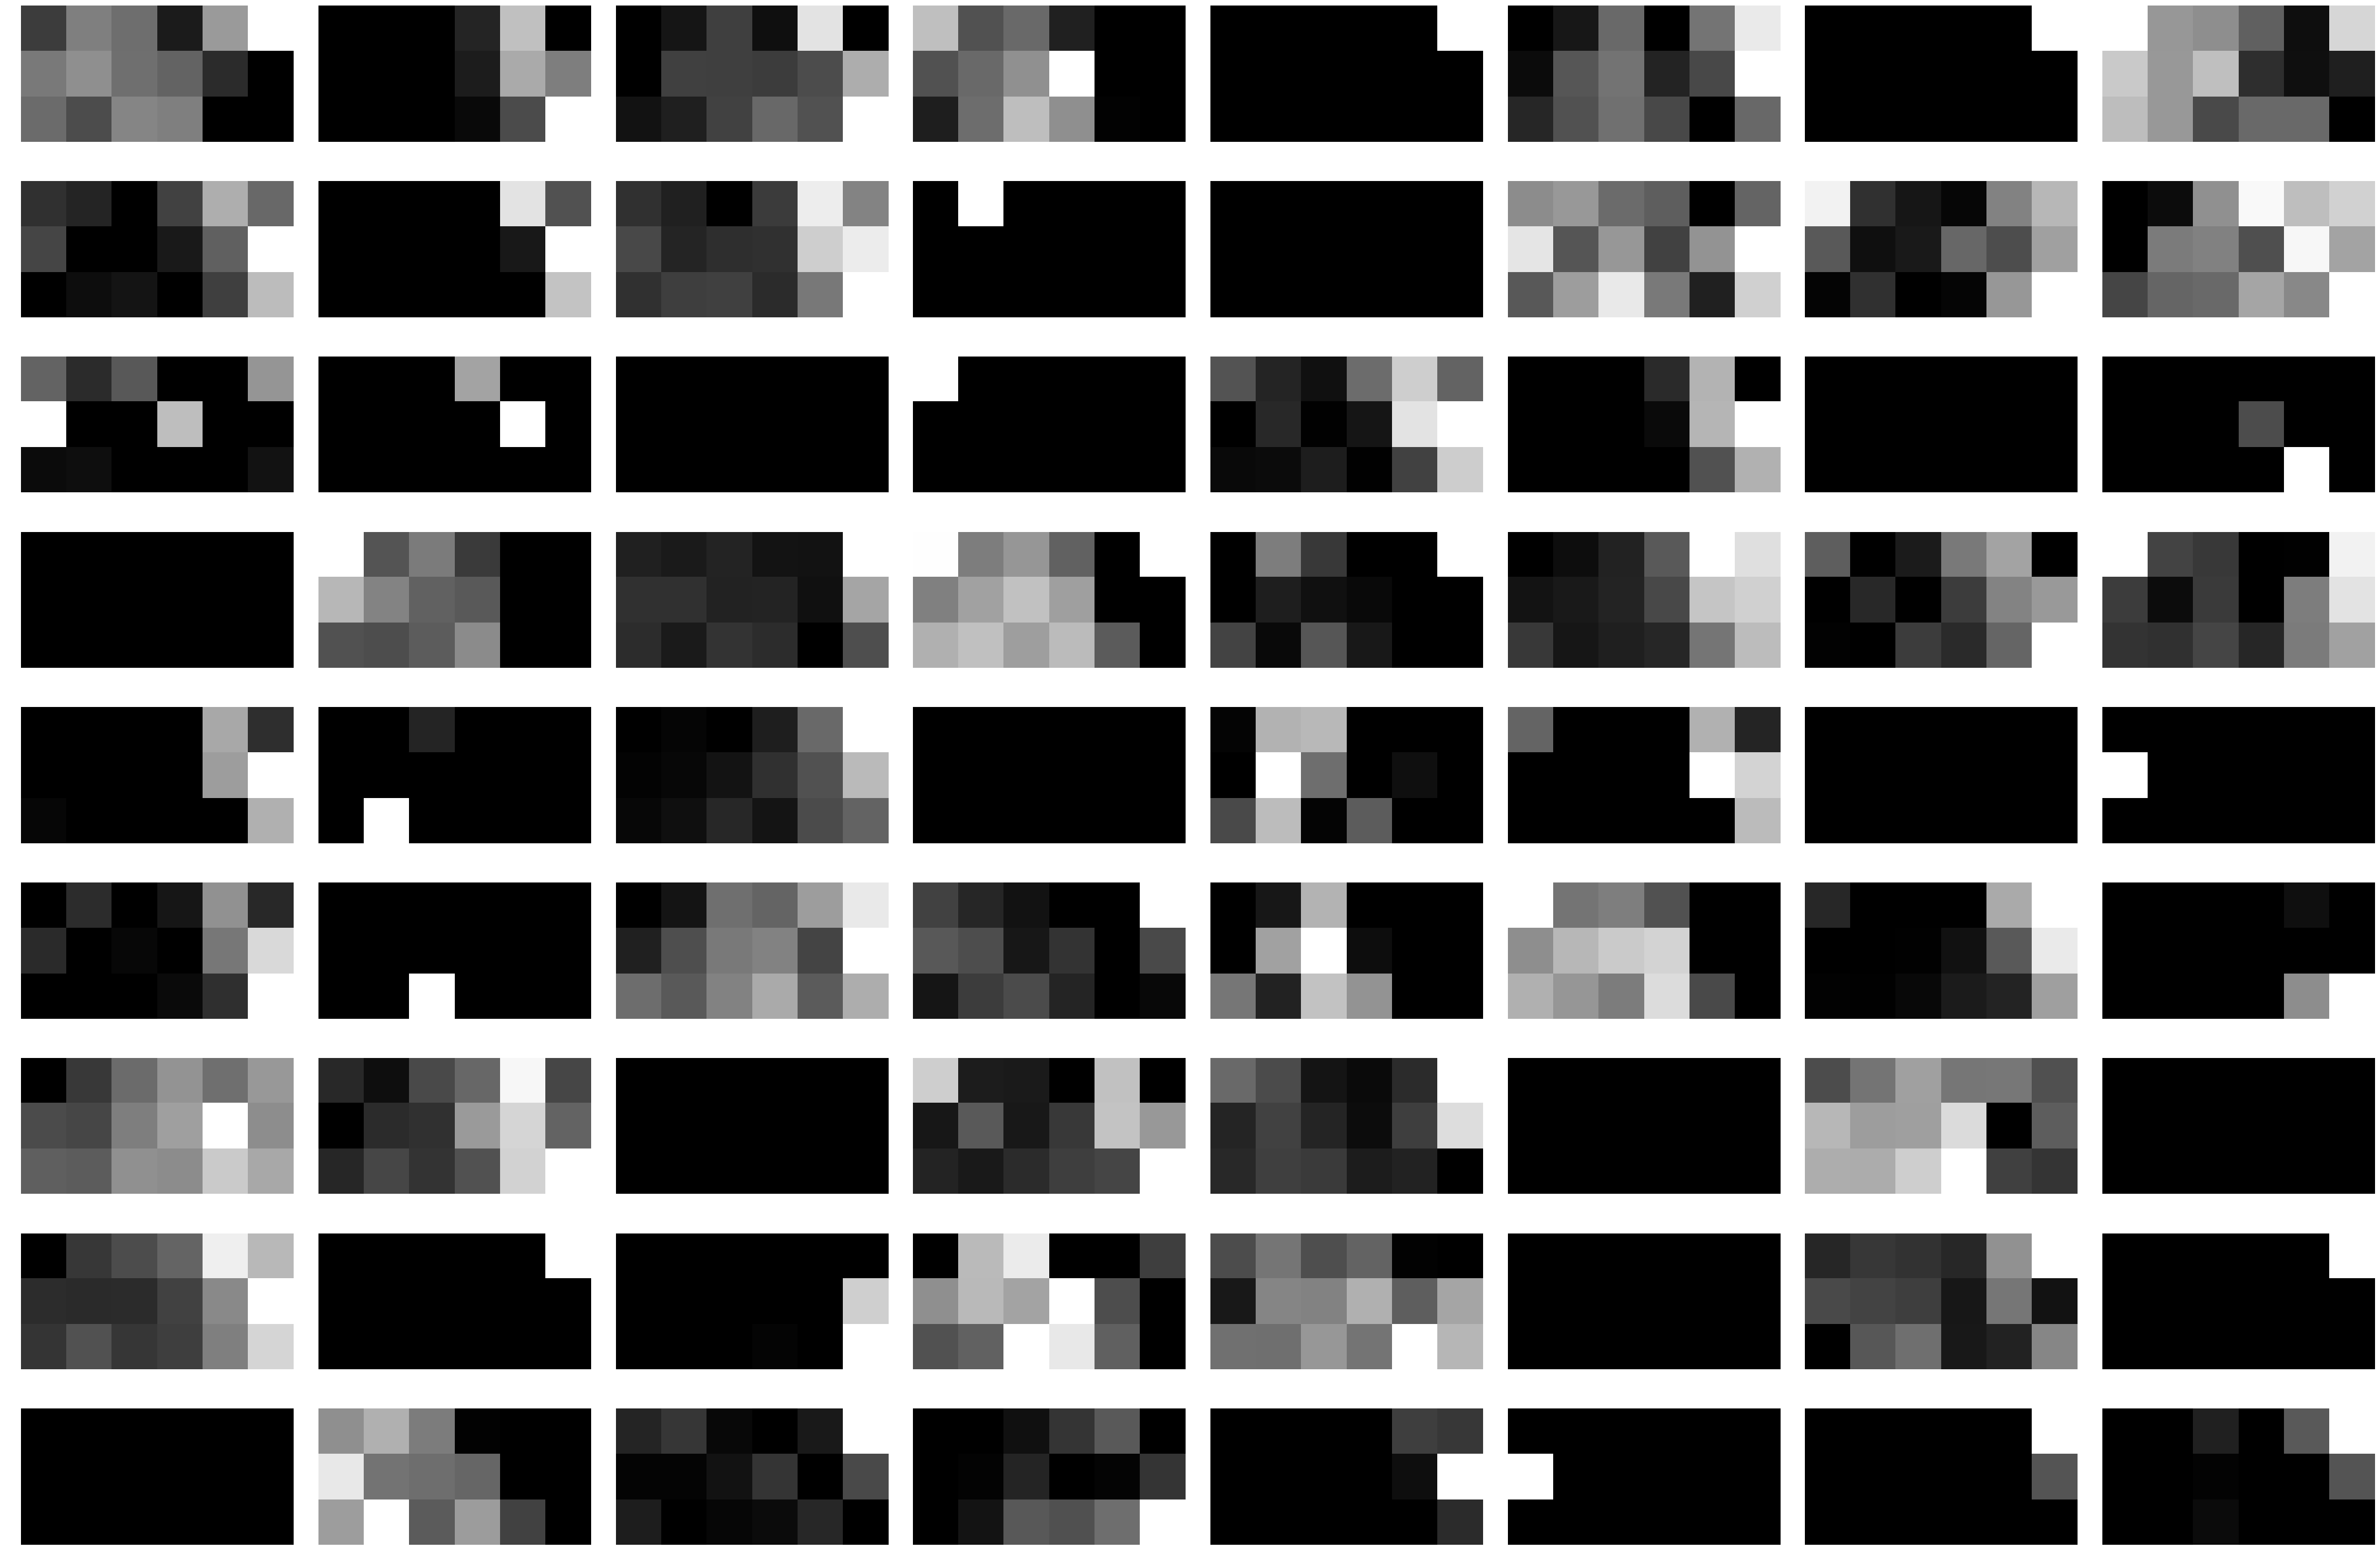

In [33]:
plotLayer(image_array_2, 7)